In [ ]:
from google.colab import drive, auth
drive.mount('/drive')
auth.authenticate_user()
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder

Mounted at /drive


In [ ]:
HOME = '/drive/MyDrive/Colab Notebooks/bangkit/'

In [ ]:
!python --version

Python 3.7.13


In [ ]:
print(tf.__version__)

2.8.2


## Training

In [ ]:
df = pd.read_csv(HOME+'exercise-train.csv')
df.dtypes

id              int64
Gender         object
Age             int64
Height          int64
Weight          int64
Duration        int64
Heart_Rate      int64
Body_Temp     float64
Calories        int64
dtype: object

In [ ]:
df.head(1)

,id,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,male,58,187,87,23,111,40.8,190


In [ ]:
target = df.pop('Calories')

In [ ]:
features = list(set(df.columns) - {'id', 'Gender'})
features

['Height', 'Age', 'Body_Temp', 'Weight', 'Duration', 'Heart_Rate']

In [ ]:
df = df[features]
df.head(1)

,Height,Age,Body_Temp,Weight,Duration,Heart_Rate
0,187,58,40.8,87,23,111


In [ ]:
tf.convert_to_tensor(df)

<tf.Tensor: shape=(10000, 6), dtype=float64, numpy=
array([[187. ,  58. ,  40.8,  87. ,  23. , 111. ],
       [165. ,  39. ,  41. ,  69. ,  30. , 108. ],
       [152. ,  60. ,  38.5,  54. ,   3. ,  86. ],
       ...,
       [172. ,  36. ,  39.3,  70. ,   7. ,  87. ],
       [165. ,  25. ,  38.4,  62. ,   3. ,  75. ],
       [190. ,  49. ,  40.5,  96. ,  28. , 103. ]])>

In [ ]:
def get_model():
  model = keras.Sequential([
                            keras.layers.Normalization(axis=1),
                            keras.layers.Dense(5, activation='relu'),
                            keras.layers.Dense(5, activation='relu'),
                            keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
  return model

In [ ]:
BATCH_SIZE = 2
model = get_model()
history = model.fit(df, target, epochs=2, batch_size=BATCH_SIZE)

Epoch 1/2
5000/5000 [==============================] - 8s 1ms/step - loss: 1496.0092 - mse: 1496.0092 - mae: 27.9242
Epoch 2/2
5000/5000 [==============================] - 7s 1ms/step - loss: 113.3700 - mse: 113.3700 - mae: 7.5853


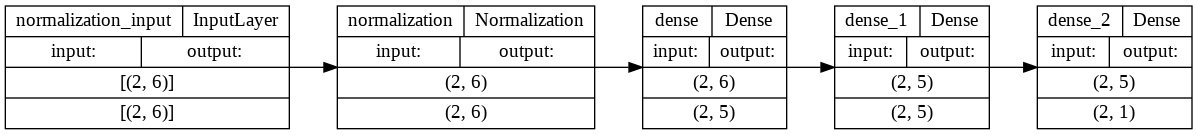

In [ ]:
keras.utils.plot_model(model, rankdir='LR', show_shapes=1)

## Deployment

In [ ]:
CLOUD_PROJECT = 'bangkit-352714'
BUCKET = 'gs://' + CLOUD_PROJECT + '-tf2-models'

In [ ]:
!gcloud config set project $CLOUD_PROJECT

Updated property [core/project].


In [ ]:
!gsutil mb $BUCKET
print(BUCKET)

Creating gs://bangkit-352714-tf2-models/...
ServiceException: 409 A Cloud Storage bucket named 'bangkit-352714-tf2-models' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
gs://bangkit-352714-tf2-models


In [ ]:
MODEL_DIR = BUCKET + '/model'
model.save(MODEL_DIR, save_format='tf')

INFO:tensorflow:Assets written to: gs://bangkit-352714-tf2-models/model/assets


In [ ]:
MODEL = 'bangkit_0'
!gcloud ai-platform models create $MODEL --region=us-east1

Using endpoint [https://us-east1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.models.create) Resource in projects [bangkit-352714] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [ ]:
# VERSION = 'v1'
# !gcloud ai-platform versions create $VERSION --model $MODEL --origin $MODEL_DIR --framework='tensorflow' --runtime-version='2.8' --region='us-east1' --python-version='3.7'

### Prediction

In [ ]:
from googleapiclient import discovery
from google.api_core.client_options import ClientOptions

In [ ]:
def predict(project, model, instances, version='v0'):
  service = discovery.build('ml', 'v1')
  name = 'projects/{}/models/{}'.format(project, model)
  name += '/versions/{}'.format(version)
  
  response = service.projects().predict(
      name=name,
      body={'instances': instances}
  ).execute()

  return response

In [ ]:
def predict_json(project, region, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        region (str): regional endpoint to use; set to None for ml.googleapis.com
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    prefix = "{}-ml".format(region) if region else "ml"
    api_endpoint = "https://{}.googleapis.com".format(prefix)
    client_options = ClientOptions(api_endpoint=api_endpoint)
    service = discovery.build(
        'ml', 'v1', client_options=client_options)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    print('requesting to {}/{}'.format(api_endpoint, name))

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    print('request executed')

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [ ]:
REGION = 'us-east1'
predict_json(CLOUD_PROJECT, REGION, MODEL, [[1, 2, 3, 4, 5, 6]], 'v1')

requesting to https://us-east1-ml.googleapis.com/projects/bangkit-352714/models/bangkit_0/versions/v1
request executed


[[16.8172703]]

In [ ]:
import requests
import json
FIELDS = ['age', 'heart', 'weight', 'temperature', 'height', 'duration']
request_json = json.dumps({'age': 1, 
            'heart': 2, 
            'weight': 3, 
            'temperature': 4, 
            'height': 5,
            'duration': 6,
            })
print(request_json)
data = json.loads(request_json)
features = []
for field in FIELDS:
  features.append(data.get(field, 1))
[features]

prediction = predict_json(CLOUD_PROJECT, REGION, MODEL, [[1, 2, 3, 4, 5, 6]], 'v1')
print(type(prediction), type(prediction[0]), prediction)
prediction_value = prediction[0][0]

res = {}
res['prediction'] = prediction_value
json.dumps(res)


{"age": 1, "heart": 2, "weight": 3, "temperature": 4, "height": 5, "duration": 6}
requesting to https://us-east1-ml.googleapis.com/projects/bangkit-352714/models/bangkit_0/versions/v1
request executed
<class 'list'> <class 'list'> [[16.8172703]]


'{"prediction": 16.8172703}'